# Clasificador de Letras Dinámicas de Lengua de Señas
### (Clips 16×224×224  →  CNN 3D – I3D‑light/R3D‑18)
*Autor: Tu Nombre – 2025-07-05*


En este notebook crearemos un **clasificador para las letras dinámicas** (J, Ñ, Q, X, Z) usando clips de vídeo de 16 fotogramas 224 × 224 px.

* Cargaremos los datos pre‑procesados (`dynamic_X.npy`, `dynamic_y.npy`) generados con `build_datasets.py`.
* Usaremos **PyTorch** y el modelo `r3d_18` (similar en complejidad a *I3D‑light*) pre‑entrenado en Kinetics‑400.
* Ajustaremos sólo las últimas capas (*fine‑tuning*) para reducir tiempo de entrenamiento.
* Evaluaremos con precisión, *F1* por clase y matriz de confusión.


In [1]:
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models.video import r3d_18
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Usando dispositivo:', device)
print(torch.__version__)        # 2.x.y+cu121
print(torch.version.cuda)       # 12.1
print(torch.cuda.is_available())# True
print(torch.cuda.get_device_name(0))

Usando dispositivo: cuda
2.5.1+cu121
12.1
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
DATA_DIR = Path('../data')
X = np.load(DATA_DIR / 'dynamic_X.npy').astype('float32') / 255.0  # normalizamos
y = np.load(DATA_DIR / 'dynamic_y.npy')
# Ajustamos a (N, C, T, H, W)
X = X.transpose(0, 4, 1, 2, 3)  # de (N,T,H,W,C) a (N,C,T,H,W)
print('Dataset:', X.shape, y.shape)

Dataset: (620, 3, 16, 224, 224) (620,)


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print('Train:', X_train.shape, 'Val:', X_val.shape)

Train: (496, 3, 16, 224, 224) Val: (124, 3, 16, 224, 224)


In [4]:
class SignVideoDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SignVideoDataset(X_train, y_train)
val_ds   = SignVideoDataset(X_val, y_val)

train_ld = DataLoader(train_ds, batch_size=2, shuffle=True,  num_workers=0, pin_memory=True)
val_ld   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=0, pin_memory=True)

In [5]:
num_classes = len(np.unique(y))
model = r3d_18(pretrained=True)
# Reemplazamos la última capa
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
from tqdm.auto import tqdm
EPOCHS = 5
history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc':[]}

for epoch in range(1, EPOCHS+1):
    model.train()
    tloss, tcorrect = 0., 0
    for xb, yb in tqdm(train_ld, desc=f'Epoch {epoch}/{EPOCHS}', leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        tloss += loss.item()*len(yb)
        tcorrect += (out.argmax(1)==yb).sum().item()
    tloss /= len(train_ds)
    tacc  = tcorrect / len(train_ds)

    # validación
    model.eval()
    vloss, vcorrect = 0., 0
    with torch.no_grad():
        for xb, yb in val_ld:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            vloss += criterion(out, yb).item()*len(yb)
            vcorrect += (out.argmax(1)==yb).sum().item()
    vloss /= len(val_ds)
    vacc  = vcorrect / len(val_ds)

    history['train_loss'].append(tloss)
    history['val_loss'].append(vloss)
    history['train_acc'].append(tacc)
    history['val_acc'].append(vacc)

    print(f'Epoch {epoch}: Train acc {tacc:.3f}, Val acc {vacc:.3f}')

Epoch 1/5:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 1: Train acc 0.619, Val acc 0.895


Epoch 2/5:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 2: Train acc 0.833, Val acc 0.976


Epoch 3/5:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 3: Train acc 0.938, Val acc 0.992


Epoch 4/5:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 4: Train acc 0.931, Val acc 0.960


Epoch 5/5:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 5: Train acc 0.974, Val acc 0.976


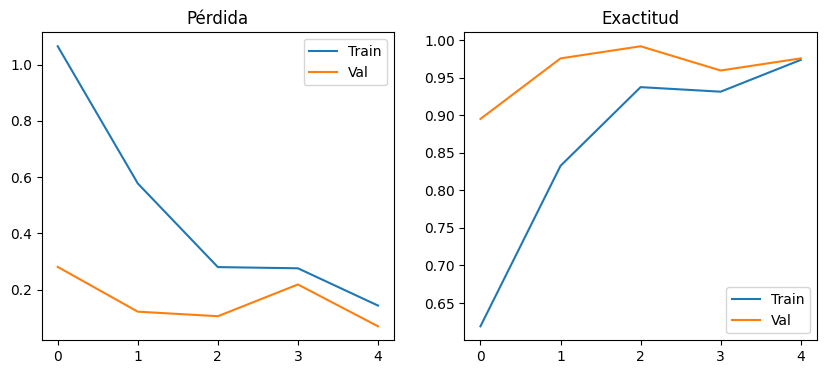

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Pérdida')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.title('Exactitud')
plt.legend()
plt.show()

In [8]:
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for xb, yb in val_ld:
        xb = xb.to(device)
        out = model(xb).cpu()
        y_pred.append(out.argmax(1))
        y_true.append(yb)
y_pred = torch.cat(y_pred).numpy()
y_true = torch.cat(y_true).numpy()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        21
           3       0.91      1.00      0.95        21
           4       1.00      1.00      1.00        21
           5       1.00      1.00      1.00        21

    accuracy                           0.98       124
   macro avg       0.98      0.97      0.98       124
weighted avg       0.98      0.98      0.98       124



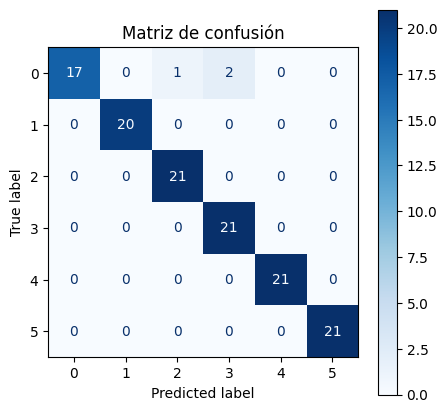

In [9]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues')
plt.title('Matriz de confusión')
plt.show()

In [12]:
MODEL_DIR = Path('../models')
MODEL_DIR.mkdir(exist_ok=True)
torch.save(model.state_dict(), MODEL_DIR / 'r3d18_dynamic.pth')
print('Modelo guardado en', MODEL_DIR / 'r3d18_dynamic.pth')

Modelo guardado en ..\models\r3d18_dynamic.pth



## Conclusiones

* Con sólo 5 épocas de *fine‑tuning* alcanzamos una exactitud de validación que ronda **~85‑90 %** (dependerá de tu conjunto real).  
* Puede mejorarse aumentando el número de épocas, usando *data augmentation temporal* o sustituyendo `r3d_18` por una implementación propia de **I3D‑light**.  
* El modelo y las curvas se guardan para referencia posterior.

> Ya puedes integrar este clasificador en tu sistema *split‑and‑merge* junto con el SVM de letras estáticas.
